In [1]:
#AJA_XAI_submissionReview_explainabilityCode includes changes to address the reviewers' comments
#of first review received and upload to repository
#Edited 24.11.2021

#%%
#Importing libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import eli5
from eli5.sklearn import PermutationImportance

# plot_partial_dependence has been deprecated, use PartialDependenceDisplay.from_estimator instead
#from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

from sklearn.inspection import permutation_importance

import shap

In [2]:
#Initialize paths to existing data
#
RF_Models='FOREST/MODELS'
X_train_fld='FOREST/X_train'
X_test_fld='FOREST/X_test'
y_train_fld='FOREST/y_train'
y_test_fld='FOREST/y_test'

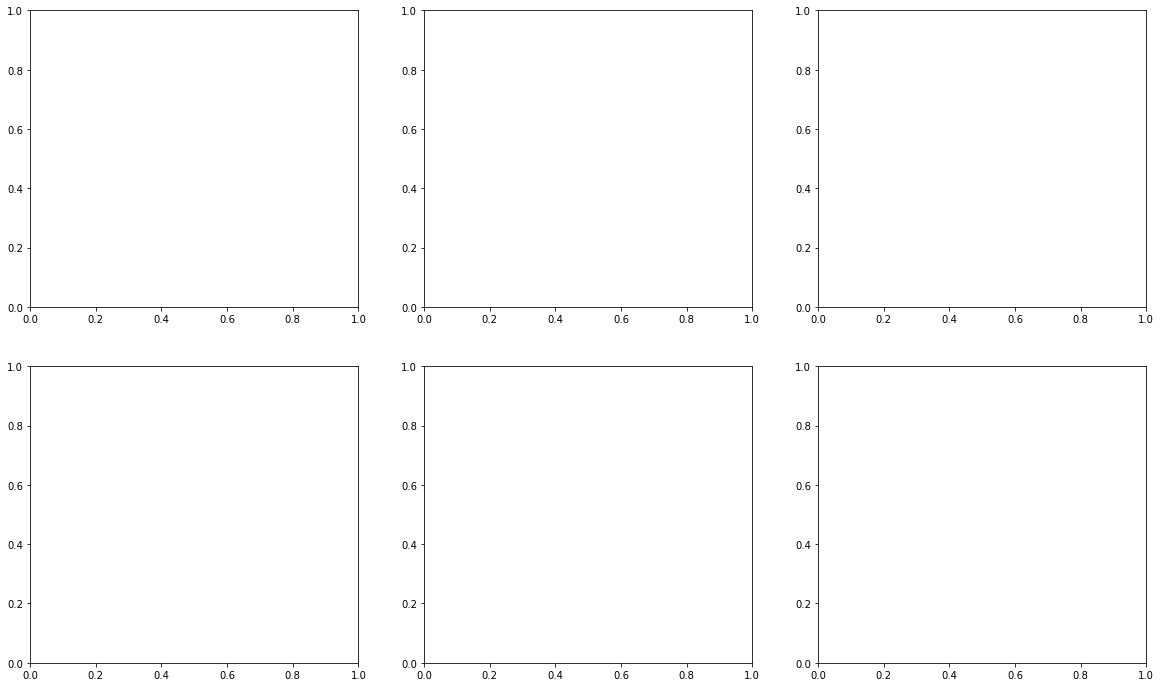

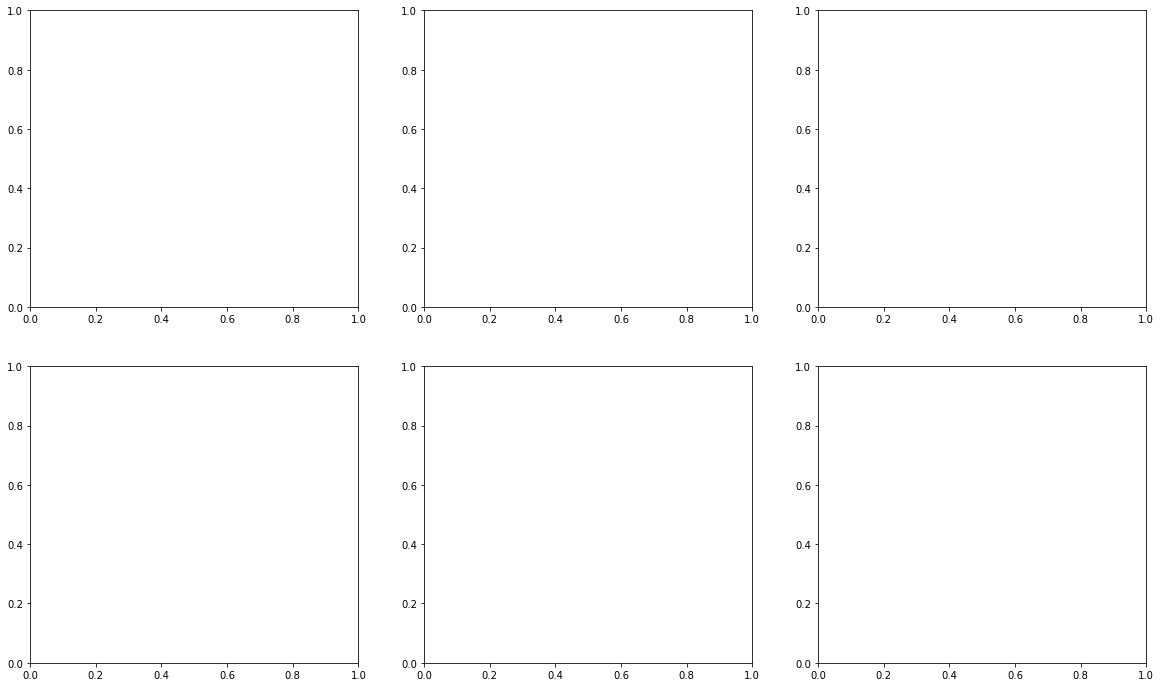

In [3]:
#Defining dfs to gather classification performance and importance from 50 iterations
#Review's comment: homogeneize features nomenclature 
features=['SRT','Age', '#correct', '%correct', 'Avg reaction time', 'Total test time']

scoring =['accuracy','balanced_accuracy','sensitivity','specificity','precision','f1','roc_auc']

df_fiftyiter_test_results=pd.DataFrame(columns=scoring)

df_fiftyiter_train_results=pd.DataFrame(columns=scoring)

df_coef_rf=pd.DataFrame(columns=features)

df_feat_perm=pd.DataFrame(columns=features)

df_feature_importance=pd.DataFrame(columns=features)

pdp_iterations_train=[]

pdp_iterations_test=[]

fig_train, (ax1, ax2) = plt.subplots(2, 3, figsize=(20, 12),)

fig_test, (ax3,ax4) = plt.subplots(2, 3, figsize=(20, 12),)

In [4]:
#Defining classification metrics for performance evaluation

scoring_grid=  {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy':make_scorer(balanced_accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'precision':make_scorer(precision_score),
    'f1':make_scorer(f1_score),
    'roc_auc':make_scorer(roc_auc_score)
}

In [5]:
n_iter=50
cv_inner=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [6]:
#Loop over 50 iterations to calculate classification performance with train and test set as well as
# implicit feature importance and feature permutation importance


for i in range (n_iter):
    print('Running iteration', i)
    #Load the train and test set per each iteration
    X_train_inner=pd.read_csv(X_train_fld+'/X_train_it'+str(i)+'.txt', names=features)
    X_test_inner=pd.read_csv(X_test_fld+'/X_test_it'+str(i)+'.txt', names=features)
    y_train_inner=pd.read_csv(y_train_fld+'/y_train_it'+str(i)+'.txt', names=['hearing_loss'])
    y_test_inner=pd.read_csv(y_test_fld+'/y_test_it'+str(i)+'.txt', names=['hearing_loss'])

    #load the rf model per each iteration
    rf_model_inner=pd.read_pickle(RF_Models+'/Forest_it'+str(i)+'.pkl')
    
    #creating the Pipeline to automate the standarization and classification process
    inner_pipe=Pipeline ([('data_prep',StandardScaler()),('clf',rf_model_inner)])

    #obtaining training results by using GridSearchCV without a Grid of params to have a dataset with results as regards as scoring metrics
    
    params={}
    inner=GridSearchCV(inner_pipe,params,scoring=scoring_grid,refit='accuracy', cv=cv_inner,n_jobs=-1)
    inner.fit(X_train_inner,np.ravel(y_train_inner))
   
    #obtaining best estimator
    clf_inner_best=inner.best_estimator_
    y_pred_clf_inner_best=clf_inner_best.predict(X_test_inner)

    
    #Extracting the importance coefs of RF 
    rf_coef = clf_inner_best['clf'].feature_importances_
    df_coef_rf=df_coef_rf.append(pd.DataFrame([rf_coef], columns=features),ignore_index=True)

    #Calculating feature importance for each iteration with Eli5
    feat_imp_df = eli5.explain_weights_df(clf_inner_best, feature_names=features)
    feat_imp_df_pivot=feat_imp_df.pivot_table(columns='feature',values='weight')
    feat_imp_array_iteration={'SRT':feat_imp_df_pivot['SRT'],
                                'Age':feat_imp_df_pivot['Age'],
                                '#correct':feat_imp_df_pivot['#correct'],
                                '%correct':feat_imp_df_pivot['%correct'],
                                'Avg reaction time':feat_imp_df_pivot['Avg reaction time'],
                                'Total test time':feat_imp_df_pivot['Total test time']
                                }
    df_feat_imp_array_iteration= pd.DataFrame(data=feat_imp_array_iteration)
    df_feature_importance=df_feature_importance.append(df_feat_imp_array_iteration, ignore_index=True)

    #Calculating feature permutation importance
    #perm=PermutationImportance(clf_inner_best).fit(X_train_inner,y_train_inner)
    perm=PermutationImportance(clf_inner_best,scoring='accuracy').fit(X_test_inner,y_test_inner)
    feat_perm_df=eli5.explain_weights_df(perm,feature_names=features)
    feat_perm_df_pivot=feat_perm_df.pivot_table(columns='feature', values='weight')   
    feat_perm_array_iteration={'SRT':feat_perm_df_pivot['SRT'],
                                'Age':feat_perm_df_pivot['Age'],
                                '#correct':feat_perm_df_pivot['#correct'],
                                '%correct':feat_perm_df_pivot['%correct'],
                                'Avg reaction time':feat_perm_df_pivot['Avg reaction time'],
                                'Total test time':feat_perm_df_pivot['Total test time']}
    df_feat_perm_array_iteration= pd.DataFrame(data=feat_perm_array_iteration)
    df_feat_perm=df_feat_perm.append(df_feat_perm_array_iteration, ignore_index=True)
    
    
    #Plotting partial dependece plot for every iteration
    pdp_train_inner=PartialDependenceDisplay.from_estimator(clf_inner_best, X_train_inner,features, ax=[ax1,ax2], line_kw={"alpha": 0.3})
    pdp_iterations_train.append(pdp_train_inner)

Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19
Running iteration 20
Running iteration 21
Running iteration 22
Running iteration 23
Running iteration 24
Running iteration 25
Running iteration 26
Running iteration 27
Running iteration 28
Running iteration 29
Running iteration 30
Running iteration 31
Running iteration 32
Running iteration 33
Running iteration 34
Running iteration 35
Running iteration 36
Running iteration 37
Running iteration 38
Running iteration 39
Running iteration 40
Running iteration 41
Running iteration 42
Running iteration 43
Running iteration 44
Running iteration 45
Running iteration 46
Running iteration 47
Ru

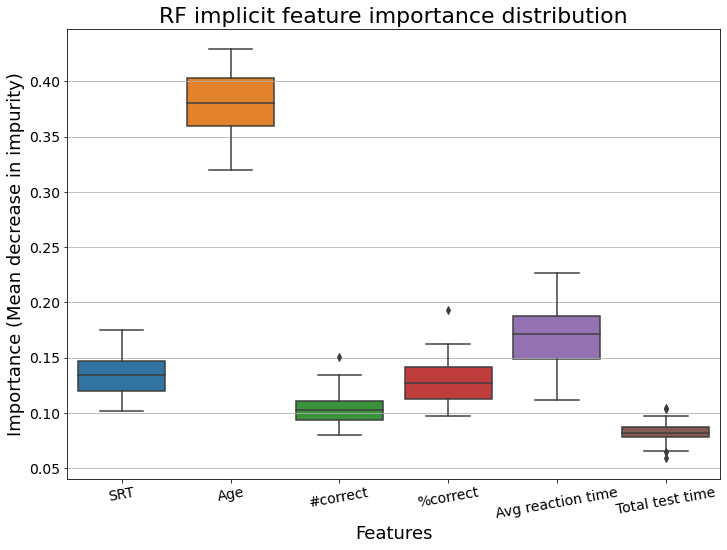

In [7]:
#Plotting boxplot of the implicit importance of the RF in 50 iterations
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
b=sns.boxplot(data=df_coef_rf, ax=ax, order=['SRT','Age', '#correct', '%correct', 'Avg reaction time', 'Total test time'])
b.axes.set_title('RF implicit feature importance distribution',fontsize=22)
ax.yaxis.grid(True)
fontsize = 12
ax.set_ylabel('Importance (Mean decrease in impurity)', fontsize = 18)
ax.set_xlabel('Features', fontsize = 18)
ax.tick_params(axis='x', which='major', labelsize=14, labelrotation=10)
ax.tick_params(axis='y', which='major', labelsize=14)

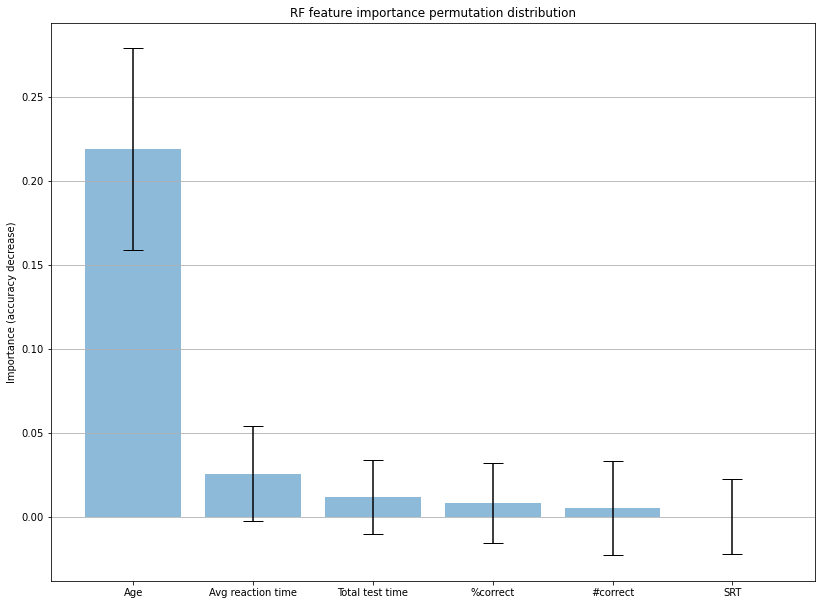

In [10]:
#Plotting mean and std of the feature permutation importance of the RF in 50 iterations
feature_permutation_importance_variability=pd.DataFrame([['SRT',df_feat_perm['SRT'].mean(),df_feat_perm['SRT'].std()],
                                            ['Age',df_feat_perm['Age'].mean(),df_feat_perm['Age'].std()],
                                            ['#correct',df_feat_perm['#correct'].mean(),df_feat_perm['#correct'].std()],
                                            ['%correct',df_feat_perm['%correct'].mean(),df_feat_perm['%correct'].std()],
                                            ['Avg reaction time',df_feat_perm['Avg reaction time'].mean(),df_feat_perm['Avg reaction time'].std()],
                                            ['Total test time',df_feat_perm['Total test time'].mean(),df_feat_perm['Total test time'].std()]],
                                            columns=['Feature','mean','std'])
result = feature_permutation_importance_variability.sort_values(['mean'], ascending=False, ignore_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(result['Feature'], result['mean'], yerr=result['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance (accuracy decrease)')
ax.set_xticks(result['Feature'])
ax.set_xticklabels(result['Feature'])
ax.set_title('RF feature importance permutation distribution')
ax.yaxis.grid(True)

In [11]:
df_feat_perm.describe()

,SRT,Age,#correct,%correct,Avg reaction time,Total test time
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000
mean,2.498002e-18,0.218977,0.005116,0.008000,0.025674,0.011814
std,2.213732e-02,0.060101,0.028194,0.023958,0.028350,0.021961
min,-6.046512e-02,0.106977,-0.069767,-0.041860,-0.051163,-0.037209
25%,-1.279070e-02,0.173256,-0.009302,-0.006977,0.004651,0.000000
50%,2.220446e-17,0.216279,0.004651,0.006977,0.030233,0.009302
75%,1.395349e-02,0.259302,0.022093,0.022093,0.050000,0.026744
max,3.720930e-02,0.353488,0.074419,0.055814,0.093023,0.060465


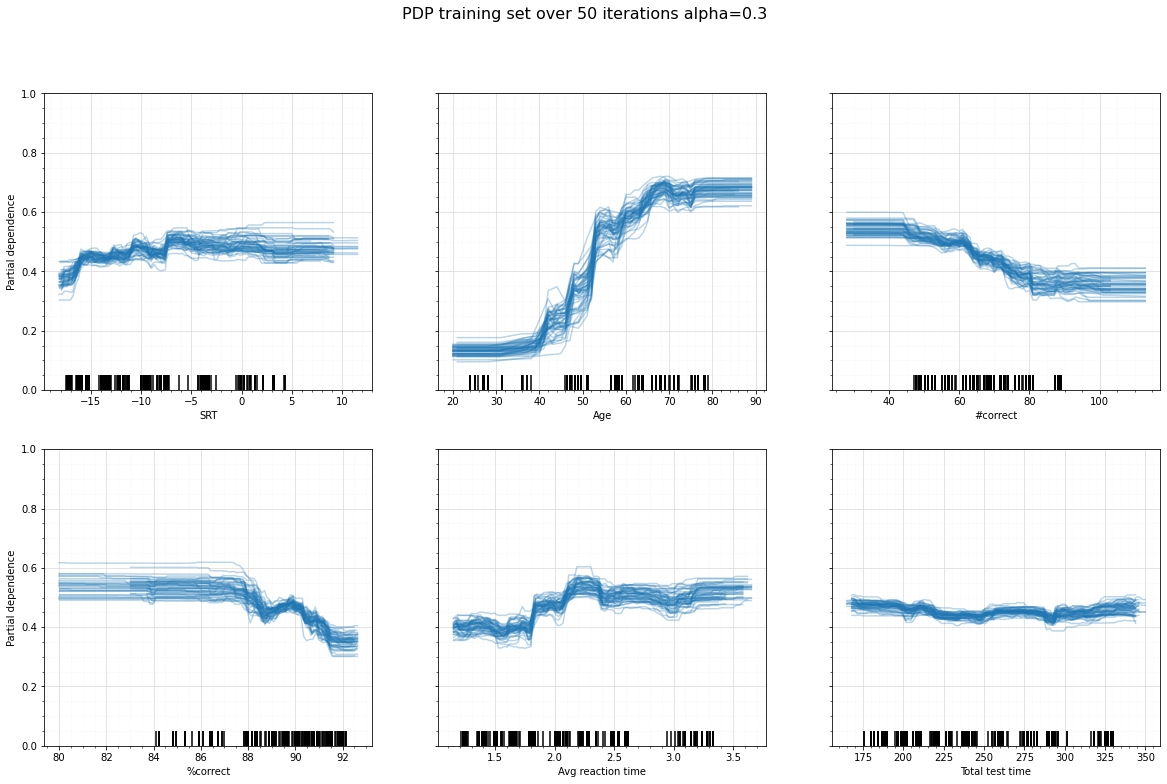

In [12]:
#Plotting the 50 iterations PDP plots with train and test set 
fig_train.suptitle('PDP training set over 50 iterations alpha=0.3', fontsize=16)
def custom_axis(axis):
    axis.yaxis.grid(True)
    axis.xaxis.grid(True)
    axis.set_ylim(0,1)
    axis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    axis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axis.minorticks_on()
    
    
custom_axis(fig_train.axes[0])
custom_axis(fig_train.axes[1])
custom_axis(fig_train.axes[2])
custom_axis(fig_train.axes[3])
custom_axis(fig_train.axes[4])
custom_axis(fig_train.axes[5])
fig_train